# Compute seismic events from simulation
This notebook shows the workflow to compute the seismic events of a simulation using the python function `extract_events`. For usage details of this function, check the source code in `qdyn/utils/postprocessing/extract_events`

In [11]:
# reload modules automatically
%load_ext autoreload
%autoreload 2

"""
INITIAL PARAMETERS
"""
import numpy as np
import pandas as pd
import os
import sys
import pickle
import matplotlib.pyplot as plt

# Add QDYN source directory to PATH
# Go up in the directory tree
# qdyn_dir = "/home/crodriguezpiceda/qdyn_intel_openmp/qdyn"
qdyn_dir = "/Users/crpiceda/Desktop/archer_work/qdyn_github/qdyn"


# Get QDYN src directory
src_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "qdyn")
)

# Append src directory to Python path
sys.path.append(src_dir)
# Get QDYN post_processing library directory
post_processing_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "qdyn", "utils", "post_processing")
)
# Append post_processing library directory to Python path
sys.path.append(post_processing_dir)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # Seconds per year

# Instantiate the QDYN class object
# p = qdyn()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First we need to read the mesh_dict, set_dict and the outputs ot, ot_fault and ot_vmax

In [12]:
# Read meshdict and set dict (needed for reading the outputs afterwards)
# directory = sys.path[0]
# test directory
directory = "/Users/crpiceda/Desktop/archer_work/models/qdyn/qdyn_github/test_vmaxfault/v9_sm_dy_0p1"
os.chdir(directory)

path_dict=os.path.join(directory,"meshdict.pkl")
dict_to_read = open(path_dict, "rb")

# assign dictionary to p.mesh_dict
p.mesh_dict = pickle.load(dict_to_read)


path_dict=os.path.join(directory,"setdict.pkl")
dict_to_read = open(path_dict, "rb")

# assign dictionary to p.mesh_dict
p.set_dict = pickle.load(dict_to_read)

# read output of fault only to save time
p.read_output(read_ot=False, read_ox=False, read_fault=True)

True

Compute events from the simulation output

In [13]:
# import function to extract events
from compute_events import compute_events

# extract events
model_dict = compute_events(p.set_dict, p.mesh_dict, p.fault)

The information per fault can be accesed by using the "fault label" as key

In [14]:
# DataFrame corresponding to event of Fault 1
model_dict["ev"][2]

,min_t,max_t,cum_slip,cum_potency,peak_v,dt_event,t_event,t_interevent_intrafault,Mw,fault_label
n_event,,,,,,,,,,
1,1.167216e+08,1.167216e+08,0.028059,728886.1,1.526869,1.60009,1.167216e+08,NaN,4.833187,2


We can plot the results of slip, peak slip rate, event duration, recurrence interval within fault, Mw, and recurrence interval between faults

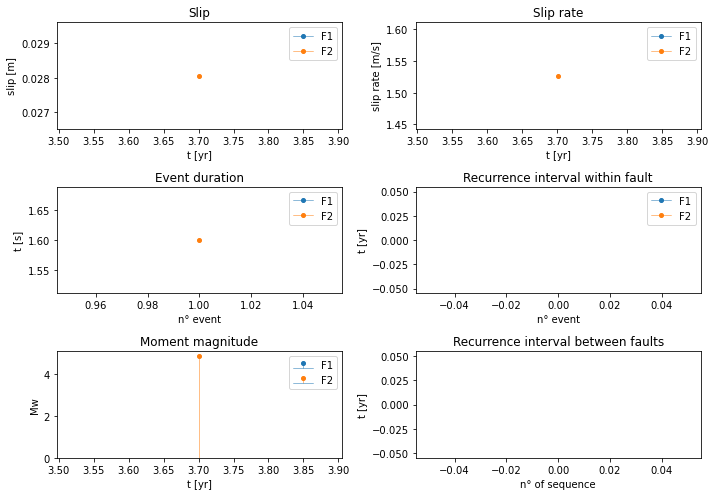

In [15]:
# plot event information
plt.close("all")

# Set the rc parameters for marker size and linewidth
plt.rc('lines', markersize=4, linewidth=0.5)

# create canvas
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 7), squeeze=False)

# Append suffix / prefix to strings in list label models

# Labels
lbl1 = "F1"
lbl2 = "F2"

# Relevant Dataframes
df_ev1 = model_dict["ev"][1] # DataFrame with events of Fault 1
df_ev2 = model_dict["ev"][2] # DataFrame with events of Fault 2
df_seq = model_dict["seq"]["1_2"] # DataFrame with interevent time between faults


## Plot quantities
#Slip
ax[0,0].plot(df_ev1["t_event"]/t_yr, df_ev1["cum_slip"], label = lbl1, marker="o")
ax[0,0].plot(df_ev2["t_event"]/t_yr, df_ev2["cum_slip"], label = lbl2, marker="o")
ax[0,0].set_xlabel("t [yr]")
ax[0,0].set_ylabel("slip [m]")
ax[0,0].legend()
ax[0,0].set_title("Slip")

# Peak slip rate
ax[0,1].plot(df_ev1["t_event"]/t_yr, df_ev1["peak_v"], label = lbl1, marker="o")
ax[0,1].plot(df_ev2["t_event"]/t_yr, df_ev2["peak_v"], label = lbl2, marker="o")
ax[0,1].set_xlabel("t [yr]")
ax[0,1].set_ylabel("slip rate [m/s]")
ax[0,1].legend()
ax[0,1].set_title("Slip rate")

# Event duration
ax[1,0].plot(df_ev1.index, df_ev1["dt_event"], label = lbl1, marker="o")
ax[1,0].plot(df_ev2.index, df_ev2["dt_event"], label = lbl2, marker="o")
ax[1,0].set_xlabel("n° event")
ax[1,0].set_ylabel("t [s]")
ax[1,0].legend()
ax[1,0].set_title("Event duration")

# Recurrence interval within fault
ax[1,1].plot(df_ev1.index, df_ev1["t_interevent_intrafault"]/t_yr, label = lbl1, marker="o")
ax[1,1].plot(df_ev2.index, df_ev2["t_interevent_intrafault"]/t_yr, label = lbl2, marker="o")
ax[1,1].set_xlabel("n° event")
ax[1,1].set_ylabel("t [yr]")
ax[1,1].legend()
ax[1,1].set_title("Recurrence interval within fault")

# Moment magnitude
markerline1, stemlines1, baseline1 = ax[2,0].stem(df_ev1["t_event"]/t_yr,df_ev1["Mw"], linefmt="#1f77b4",label = "F1", markerfmt='o', basefmt= 'C0')
plt.setp(stemlines1, 'color', plt.getp(markerline1,'color'))
markerline2, stemlines2, baseline2 = ax[2,0].stem(df_ev2["t_event"]/t_yr,df_ev2["Mw"], linefmt="orange",label = "F2", markerfmt='o', basefmt= 'C0')
plt.setp(stemlines2, 'color', plt.getp(markerline2,'color'))
ax[2,0].set_ylim(bottom=0)
ax[2,0].set_xlabel("t [yr]")
ax[2,0].set_ylabel("Mw")
ax[2,0].legend()
ax[2,0].set_title("Moment magnitude")

# Recurrence interval between faults
ax[2,1].scatter(df_seq.index, df_seq["t_interevent_interfault"]/t_yr, marker="o")
ax[2,1].set_xlabel("n° of sequence")
ax[2,1].set_ylabel("t [yr]")
ax[2,1].set_title("Recurrence interval between faults")



fig.tight_layout()       
plt.show()

Next we can extract the location of nucleation points and its spatial frequency

In [20]:
# reload modules automatically
%load_ext autoreload
%autoreload 2

# import function to extract events
from nucleation_point import nucleation_point

# Add to model_dict the information about nucleation points
model_dict_np = nucleation_point(p.mesh_dict, model_dict)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Empty DataFrame
Columns: [x, y, z, count_np, i_np]
Index: []
                 x           y            z  count_np     i_np
i_np                                                          
40516  1337.890625  864.285714 -4676.218311         1  40516.0


The information of the location point is stored in `model_dict_np["np"][<fault_label>]`. This includes: index (n event), step (timestep of nucleation), potcy_fault (potency of fault), pot_rate_fault (potency rate of the fault), vmax_fault (peak velocity at that timestep), ivmax_fault (index of element with peak velocity at nucleation), cum_slip_fault (cumulative slip of the fault from start of simualtion), fault_label, deltat (time duration of event), n_event, and coordinates x y z of nucleation point. 

The information of the location point frequency is stored in `model_dict_np["count_np"][<fault_label>]`. This includes: coordinates x y z, fault_label and count_np (absolute frequency)

In [25]:
# print information of location point for Fault 2
model_dict_np["np"][2]

,step,t,potcy_fault,pot_rate_fault,vmax_fault,ivmax_fault,deltat,n_event,cum_slip_fault,x,y,z,Mw
n_event,,,,,,,,,,,,,
1,320,1.167216e+08,172745.8,5010.782,0.010796,40517,NaN,1,0.00665,1337.890625,864.285714,-4676.218311,4.833187


In [23]:
# print information of location point frequency for Fault 2
model_dict_np["count_np"][2]

,x,y,z,fault_label,count_np
0,9.765625,107.142857,-5987.628209,2,NaN
1,29.296875,107.142857,-5987.628209,2,NaN
2,48.828125,107.142857,-5987.628209,2,NaN
3,68.359375,107.142857,-5987.628209,2,NaN
4,87.890625,107.142857,-5987.628209,2,NaN
...,...,...,...,...,...
26875,4912.109375,1592.857143,-3414.295580,2,NaN
26876,4931.640625,1592.857143,-3414.295580,2,NaN
26877,4951.171875,1592.857143,-3414.295580,2,NaN
26878,4970.703125,1592.857143,-3414.295580,2,NaN
